### Create neural heatmap plots

In [1]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import itertools
from nilearn import image, plotting, datasets
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
import nibabel as nib
import pdb
import os
import hemispace_params as params
import scipy.stats as stats

#hide warning
import warnings
warnings.filterwarnings("ignore")


In [2]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir

sub_info = params.sub_info
task_info = params.task_info
thresh = params.thresh

suf = params.suf
rois = params.rois
hemis = params.hemis


#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')

#extract just patients from group
#sub_info = sub_info[sub_info['group']=='patient']

#load mni mask
mni = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')
#binarize mni
mni_binary = image.math_img('img > 0', img=mni)

roi_dir = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/'




In [14]:
'''
Count number of subs with significant voxels
'''
control_subs = sub_info[sub_info['group']=='control']

#loop through conds
for cond in task_info['cond']:
    curr_n = 0

    if cond == 'word' or cond == 'face':
        task_type = 'ventral_tasks'
    elif cond == 'tool' or cond == 'space':
        task_type = 'dorsal_tasks'

    for sub in control_subs['sub']:
        sub_dir = f'{data_dir}/{sub}/ses-01'

        #check if neural map exists
        neural_map_path = f'{sub_dir}/derivatives/neural_map/{cond}_func.npy'

        if os.path.exists(neural_map_path):
            
            #load neural map
            neural_map = np.load(neural_map_path)

            #calcualte max
            max_val = np.max(neural_map)
            
            if max_val > 0:
                curr_n += 1

    #run binomial test
    result = stats.binomtest(curr_n, control_subs[f'{task_type}'].sum(), p=0.5, alternative='greater')

    print(f'{cond}: {curr_n} /', control_subs[task_type].sum(), f'p={result.pvalue}')




word: 20 / 21 p=1.049041748046875e-05
face: 20 / 21 p=1.049041748046875e-05
tool: 24 / 24 p=5.960464477539063e-08
space: 24 / 24 p=5.960464477539063e-08


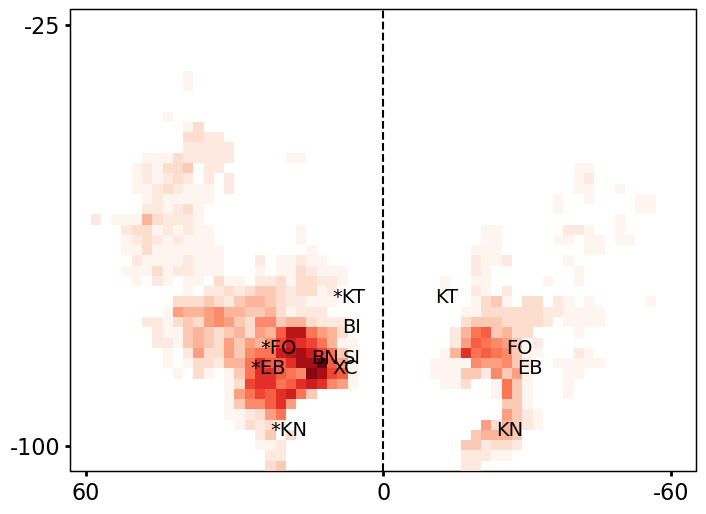

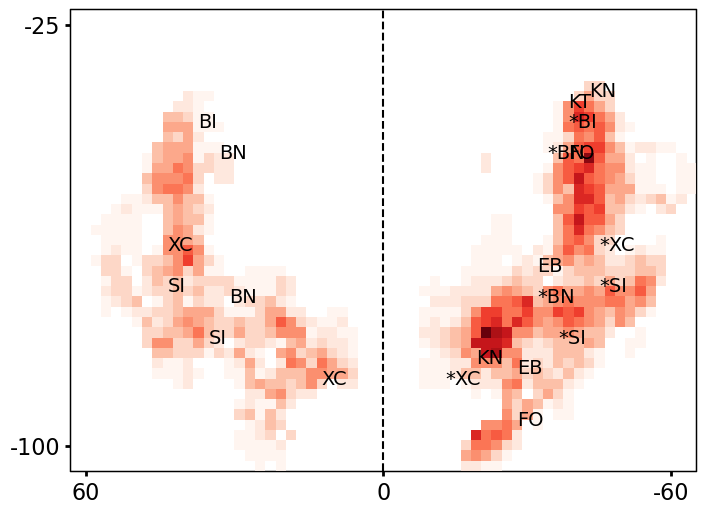

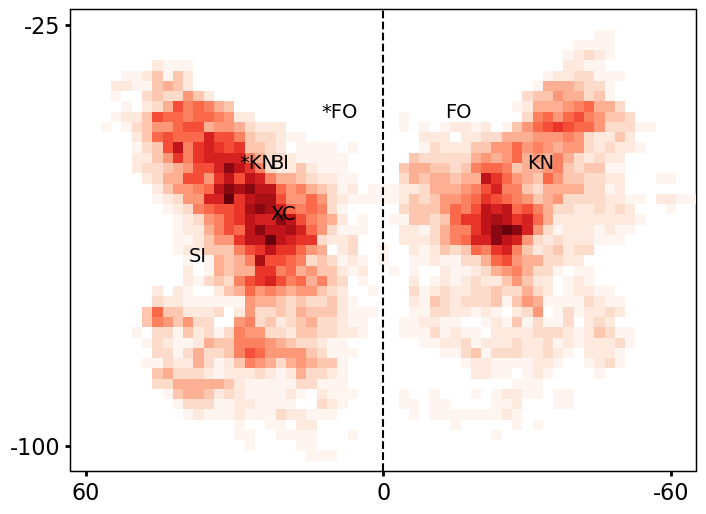

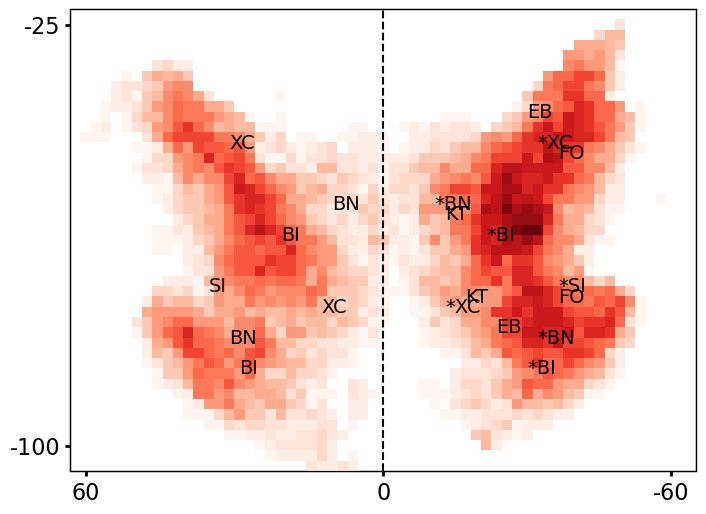

In [3]:
'''plot patient on controls'''

#set limits on matrix
min_val = [10]
max_val = [55]
y_cut = 15
x_cut = 15
mid_adjust = .5


#extract patient data
patient_subs = sub_info[sub_info['group']=='patient']

conds = ['word','face','tool','space']
pref_side = ['left','right','left','right']
midlines = [17, 17, 17, 17]

for cond, pref, split in zip(conds,pref_side, midlines):

    if cond == 'face' or cond == 'space':
        positions = ['posterior','anterior']
    elif cond == 'word':
        positions = ['posterior']
    elif cond == 'tool':
        positions = ['anterior']
    

    #load map
    neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')

    #remove lower and upper bounds of matrix
    #neural_map = neural_map[y_cut:-y_cut, x_cut:-x_cut]
    neural_map = neural_map[min_val[0]:max_val[0], x_cut:-x_cut]

    #convert to percent of max
    neural_map = neural_map/np.max(neural_map)

    #keep top 10% th
    #neural_map[neural_map < .5] = 0
    #replace 0 with nan
    neural_map[neural_map == 0] = np.nan

    plt.figure(figsize=(10,6))

    plt.imshow(neural_map, cmap='Reds')
    #add dashed vertical line at midline
    plt.axvline(x=neural_map.shape[1]/2-mid_adjust, color = 'black', linestyle = '--')


    for sub, sub_code, hemi in zip(patient_subs['sub'],patient_subs['code'], patient_subs['intact_hemi']): 
        sub_dir = f'{data_dir}/{sub}/ses-01/derivatives/neural_map'
        #check if sub has neural map for cond
        if os.path.exists(f'{sub_dir}/{cond}_func.npy'):
            
            neural_map = np.load(f'{sub_dir}/{cond}_func.npy')
            neural_map = neural_map[min_val[0]:max_val[0], x_cut:-x_cut]
            #neural_map = neural_map[y_cut:-y_cut, x_cut:-x_cut]

            #mask out contralateral hemisphere
            if hemi == 'left':
                neural_map[:,:int(neural_map.shape[1]/2)] = 0
                text_color = '#ee7183'
            elif hemi == 'right':
                neural_map[:,int(neural_map.shape[1]/2):] = 0
                text_color = '#7398af'     


            if hemi == pref:
                sides = [1]
            else:
                sides = [1,2]

            

            for side in sides:
                if side ==1:
                    curr_map = neural_map
                    curr_code = sub_code

                else:
                    curr_map = np.flip(neural_map, axis = 1)
                    curr_code = f'*{sub_code}'


                #check if there should be a posterior and anterior ROI
                if split != 0:
                    for position in positions:
                        if position == 'posterior':
                            peak = np.max(curr_map[:split,:])
                        elif position == 'anterior':
                            peak = np.max(curr_map[split:,:])

                        if peak != 0:
                            peak_coord = np.where(curr_map == peak)



                            #annotate heatmap with sub code at peak voxel
                            #plt.text(peak_coord[1], peak_coord[0], sub_code, color = 'black',fontsize=12,bbox=dict(facecolor=text_color,alpha = .6, edgecolor=text_color, boxstyle='round'))
                            plt.text(peak_coord[1], peak_coord[0], curr_code, color = 'black',fontsize=14)

                else:
                    peak = np.max(curr_map[split:,:])
                    if peak != 0:
                        peak_coord = np.where(curr_map == peak)

                        #annotate heatmap with sub code at peak voxel
                        #plt.text(peak_coord[1], peak_coord[0], sub_code, color = 'black',fontsize=12,bbox=dict(facecolor=text_color,alpha = .6, edgecolor=text_color, boxstyle='round'))
                        plt.text(peak_coord[1], peak_coord[0], curr_code, color = 'black',fontsize=14)

                


            

    #add title
    #plt.title(f'{cond} patient on controls')
    
    ax = plt.gca()

    ax.yaxis.set_ticks([2, curr_map.shape[0]-2])
    ax.yaxis.set_ticklabels([-100, -25])
    
    ax.xaxis.set_ticks([2,curr_map.shape[1]/2-mid_adjust, curr_map.shape[1]-2])
    ax.xaxis.set_ticklabels([-60, 0, 60])

    #increase font size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)  

    ax.tick_params('both',  width=2, which='major')

    #flip y axis
    plt.gca().invert_yaxis()
    #flip x axis
    plt.gca().invert_xaxis()
    #plt.xticks([])
    #plt.yticks([])
    

    plt.savefig(f'{fig_dir}/maps/{cond}_patient_on_controls.png', dpi = 300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
   
            